In [2]:
# !pip install pyspark

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob
import re
from nltk.sentiment import SentimentIntensityAnalyzer


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType, DoubleType

import seaborn as sns

from wordcloud import WordCloud
from textblob import TextBlob
import re

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Load dataset file
dataset = pd.read_csv('/content/drive/MyDrive/Data/ProjectTweets.csv')

In [6]:
dataset.head(10)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,6,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,7,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,8,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,9,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,10,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [8]:
# Drop the first column
dataset = dataset.drop('0',axis =1)

In [9]:
# Make geader of the dataset or assign columns
dataset.columns = ['id','date','flag','username','tweets']

In [11]:
dataset.head(5)

,id,date,flag,username,tweets
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Now save the dataset with column names
dataset.to_csv('tweets.csv')

In [12]:
# Create a Spark session
spark = SparkSession.builder.appName("Catch_tweets").getOrCreate()

In [21]:
# Load the CSV file into a Spark DataFrame
tweets_data = spark.read.csv("/content/drive/MyDrive/Data/tweets.csv", header=True, inferSchema=True)

In [22]:
# Define the schema for your data
schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

# Load the CSV data into a DataFrame
tweets_df = spark.read.csv("/content/drive/MyDrive/Data/tweets.csv", header=True, schema=schema)

In [24]:
# Display the resulting DataFrame
tweets_data.show()

+----------+-------------------+--------+---------------+--------------------+
|        id|               date|    flag|       username|              tweets|
+----------+-------------------+--------+---------------+--------------------+
|1467810672|2009-04-06 22:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|1467810917|2009-04-06 22:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|1467811184|2009-04-06 22:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|1467811193|2009-04-06 22:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
|1467811372|2009-04-06 22:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|1467811592|2009-04-06 22:20:03|NO_QUERY|        mybirch|         Need a hug |
|1467811594|2009-04-06 22:20:03|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|1467811795|2009-04-06 22:20:05|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|1467812025|2009-04-06 22:20:09|NO_QUERY|        mimismo|@twittera que me ...|
|1467812416|2009-04-06 22:20:16|NO_QUERY| erinx3lean

In [28]:
# show total number of rows
print(tweets_data.count())

1599999


In [29]:
# Define a user-defined function (UDF) for sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Classify polarity as 'positive', 'negative', or 'neutral'
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'

    else:
        return 'neutral'

In [30]:
# Register the UDF (analyze_sentiment function) with Spark
sentiment_udf = udf(analyze_sentiment, StringType())

In [31]:
#Apply Text_blob method to tweets column and then add the sentiments of tweets in sentiments column
tweets_data = tweets_data.withColumn("sentiments", sentiment_udf("tweets"))

In [32]:
tweets_data.show(n=3)

+----------+-------------------+--------+-------------+--------------------+----------+
|        id|               date|    flag|     username|              tweets|sentiments|
+----------+-------------------+--------+-------------+--------------------+----------+
|1467810672|2009-04-06 22:19:49|NO_QUERY|scotthamilton|is upset that he ...|   neutral|
|1467810917|2009-04-06 22:19:53|NO_QUERY|     mattycus|@Kenichan I dived...|  positive|
|1467811184|2009-04-06 22:19:57|NO_QUERY|      ElleCTF|my whole body fee...|  positive|
+----------+-------------------+--------+-------------+--------------------+----------+
only showing top 3 rows



In [33]:
# convert sentiments column into integer
from pyspark.sql.functions import when


sentiment_mapping = {"positive": 1, "negative": 2, "neutral": 0}

# Create a new column 'label' using when and otherwise
tweets_data = tweets_data.withColumn(
    "label",
    when(tweets_data["sentiments"] == "positive", sentiment_mapping["positive"])
    .when(tweets_data["sentiments"] == "negative", sentiment_mapping["negative"])
    .otherwise(sentiment_mapping["neutral"])
)


In [34]:
tweets_data.show(n=4)

+----------+-------------------+--------+-------------+--------------------+----------+-----+
|        id|               date|    flag|     username|              tweets|sentiments|label|
+----------+-------------------+--------+-------------+--------------------+----------+-----+
|1467810672|2009-04-06 22:19:49|NO_QUERY|scotthamilton|is upset that he ...|   neutral|    0|
|1467810917|2009-04-06 22:19:53|NO_QUERY|     mattycus|@Kenichan I dived...|  positive|    1|
|1467811184|2009-04-06 22:19:57|NO_QUERY|      ElleCTF|my whole body fee...|  positive|    1|
|1467811193|2009-04-06 22:19:57|NO_QUERY|       Karoli|@nationwideclass ...|  negative|    2|
+----------+-------------------+--------+-------------+--------------------+----------+-----+
only showing top 4 rows



In [35]:
data = tweets_data.select('tweets','label')
data.show()

+--------------------+-----+
|              tweets|label|
+--------------------+-----+
|is upset that he ...|    0|
|@Kenichan I dived...|    1|
|my whole body fee...|    1|
|@nationwideclass ...|    2|
|@Kwesidei not the...|    1|
|         Need a hug |    0|
|@LOLTrish hey  lo...|    1|
|@Tatiana_K nope t...|    0|
|@twittera que me ...|    0|
|spring break in p...|    2|
|I just re-pierced...|    0|
|@caregiving I cou...|    0|
|@octolinz16 It it...|    0|
|@smarrison i woul...|    1|
|@iamjazzyfizzle I...|    0|
|Hollis' death sce...|    0|
|about to file taxes |    0|
|@LettyA ahh ive a...|    1|
|@FakerPattyPattz ...|    0|
|@alydesigns i was...|    1|
+--------------------+-----+
only showing top 20 rows



In [36]:
data_100 = data.limit(100)

In [97]:
print(data_100.count())

100


In [37]:
#Divide data into 70% for training, 30% for testing

(trainingData , testingData) = data.randomSplit([0.7, 0.3])

# train_rows = trainingData.count()
# test_rows = testingData.count()

# print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

In [38]:
# Clean the tweets column
def clean_text(text):
    # You can customize this function based on your specific cleaning requirements
    # For now, let's remove mentions, hashtags, and special characters
    cleaned_text = ' '.join([word for word in text.split() if not word.startswith('@') and not word.startswith('#')])
    cleaned_text = ''.join(e for e in cleaned_text if e.isalnum() or e.isspace())
    return cleaned_text

In [39]:
# Register the UDF (clean_text function) with Spark
clean_udf = udf(clean_text, StringType())

In [40]:
trainingData = trainingData.withColumn("tweets", clean_udf(("tweets")))

In [62]:
# Separate "tweets" into individual words using tokenizer
tokenizer = Tokenizer(inputCol="tweets", outputCol="tweetWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=5)

+-------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+
|tweets                                                                                                       |label|tweetWords                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+
|I missed the New Moon trailer                                                                                |1    |[i, missed, the, new, moon, trailer]                                                                                     

In [63]:
# Removing stop words (unimportant words to be features)
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(),
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=5)

+-------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|tweets                                                                                                       |label|tweetWords                                                                                                                             |MeaningfulWords                                                                                   |
+-------------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------

In [64]:
# Converting words feature into numerical feature withHashingTF funtion for model training
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=False, n=3)

+-----+------------------------------------------------------------+---------------------------------------------------------------------------------------+
|label|MeaningfulWords                                             |features                                                                               |
+-----+------------------------------------------------------------+---------------------------------------------------------------------------------------+
|1    |[missed, new, moon, trailer]                                |(262144,[64344,89833,165360,201103],[1.0,1.0,1.0,1.0])                                 |
|2    |[noooooooooo, friends, twitter, makes, sad, someone, follow]|(262144,[1512,125638,130047,148039,182401,199581,213767],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|1    |[want, hear, guess, thats, asking, much]                    |(262144,[10345,76764,111370,137949,189716,190256],[1.0,1.0,1.0,1.0,1.0,1.0])           |
+-----+---------------------------------------------------

In [70]:
train_data = numericTrainData.select('features','label')

***Modeling***

In [81]:
# Train our classifier model using training data
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label",
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

In [82]:
# apply clean function to testing tweets
testingData = testingData.withColumn("tweets", clean_udf(("tweets")))

In [83]:
# Prepare testing data
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'Label', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)

In [84]:
# Predict testing data and calculate the accuracy model
prediction = model.transform(numericTest)
predictionFinal = prediction.select(
    "MeaningfulWords", "prediction", "Label")
predictionFinal.show(n=4, truncate = False)
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['Label']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData,
      ", accuracy:", correctPrediction/totalData)

**Store data into mongodb database**

In [146]:
# !pip install pymongo
# ! python -m pip install python-dotenv
import pymongo
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [140]:
# Create a new client and connect to the server
# url = "mongodb://localhost:27017"
# client = MongoClient(url)

In [143]:
# database_name = 'tweets_data'
# collection_name = 'tweets'

# # Defining database and a collection variable to fetch data from Mongo DB
# db = client[database_name]
# collection = db[collection_name]

In [144]:
# Importing stored data from mongo DB to list variable ,documents
# documents = list(collection.find())

In [145]:
# dframe = pd.DataFrame(documents)

In [ ]:
# Save the spark DataFrame to a CSV file
# tweets_data.coalesce(1).write.csv('sentiments.csv', header=True, mode='overwrite')

In [41]:
# read data file
df = pd.read_csv('/content/drive/MyDrive/Data/tweets.csv')

In [42]:
df.isnull().sum()

id          0
date        0
flag        0
username    0
tweets      0
dtype: int64

In [44]:
df = df.sample(n=5000, random_state=42)

In [45]:
# import vader_lexicon model
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [46]:
# Initialize SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [48]:
# apply Vader analyzer to just random tweet from data
sia.polarity_scores(df['tweets'][750])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [51]:
# Defining a function for getting the polarity of the tweets
def analyze_sentiment(text):
    # Get the compound sentiment score
    compound_score = sia.polarity_scores(text)['compound']

    # Classify polarity as 'positive', 'negative', or 'neutral' based on the compound score
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [52]:
#Applying function
df['sentiments'] = df['tweets'].apply(analyze_sentiment)

In [53]:
# Converting sentiments column to numerical representations
category_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}

df['label'] = df['sentiments'].map(category_mapping)

In [57]:
df.head(10)

,id,date,flag,username,tweets,sentiments,label
678142,2248889210,2009-06-19 21:21:22,NO_QUERY,aileenabigail,better get ready to go to work..,positive,1
1357729,2048071111,2009-06-05 14:37:04,NO_QUERY,keza34,"@Dojie blonde,posh with a beard.lol not my cup...",neutral,0
1237115,1992957675,2009-06-01 09:35:55,NO_QUERY,mesohapi,@imalexevans you're not the only one,neutral,0
238487,1980425957,2009-05-31 06:42:32,NO_QUERY,Joachim65,Regarding my last tweet - I don't think human ...,neutral,0
1423712,2058741875,2009-06-06 15:32:25,NO_QUERY,littletoia,high expectations for toniiiighhhttt,neutral,0
624090,2229786757,2009-06-18 16:12:19,NO_QUERY,PalaceJackson,@charlottespeech I never got a bell,neutral,0
1328990,2015597610,2009-06-03 05:04:16,NO_QUERY,thissideoftown,Off to final number eins and two. Today is my ...,positive,1
790273,2325616056,2009-06-25 05:46:27,NO_QUERY,q_ueenie,packing for my epic weekend dunno which dress...,neutral,0
786879,2324761463,2009-06-25 03:59:03,NO_QUERY,allikatetor,im so tired but i cant sleep cause my teeth hu...,negative,2
497748,2185983248,2009-06-15 18:11:20,NO_QUERY,misschris715,why aren't u responding to me on aim?,neutral,0


In [58]:
# drop flag column because its useless
df.drop('flag',axis=1, inplace=True)

In [60]:
# Convert the 'Datetime' column to pandas datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df['date'] = df['date'].dt.date

# Set 'date' as the index for time series analysis
df.set_index('date', inplace=True)

# Sort the DataFrame based on the date index
df.sort_index(inplace=True)

In [61]:
def clean_tweet(tweet):
    # Remove links
    tweet = re.sub(r'http\S+', '', tweet)

    # Remove words starting with '@' (user mentions)
    tweet = re.sub(r'@\S+', '', tweet)

    # Remove special characters and numbers
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    return tweet

In [ ]:
# Apply the cleaning function to the 'tweets' column
df['tweets'] = df['tweets'].apply(clean_tweet)

In [ ]:
df.head(5)

,date,id,flag,username,tweets,sentiments,label
541200,2009-06-16 18:18:13,2200003313,NO_QUERY,DEWGetMeTho77,my poor little dumpling in holmdel vids he w...,negative,2
750,2009-04-06 23:11:18,1467998601,NO_QUERY,Young_J,im off too bed i gotta wake up hella early tom...,neutral,0
766711,2009-06-23 13:40:12,2300049112,NO_QUERY,dougnawoschik,i havent been able to listen to it yet my spe...,neutral,0
285055,2009-06-01 10:26:09,1993474319,NO_QUERY,thireven,now remembers why solving a relatively big equ...,negative,2
705995,2009-06-20 12:56:51,2256551006,NO_QUERY,taracollins086,ate too much feel sick,negative,2


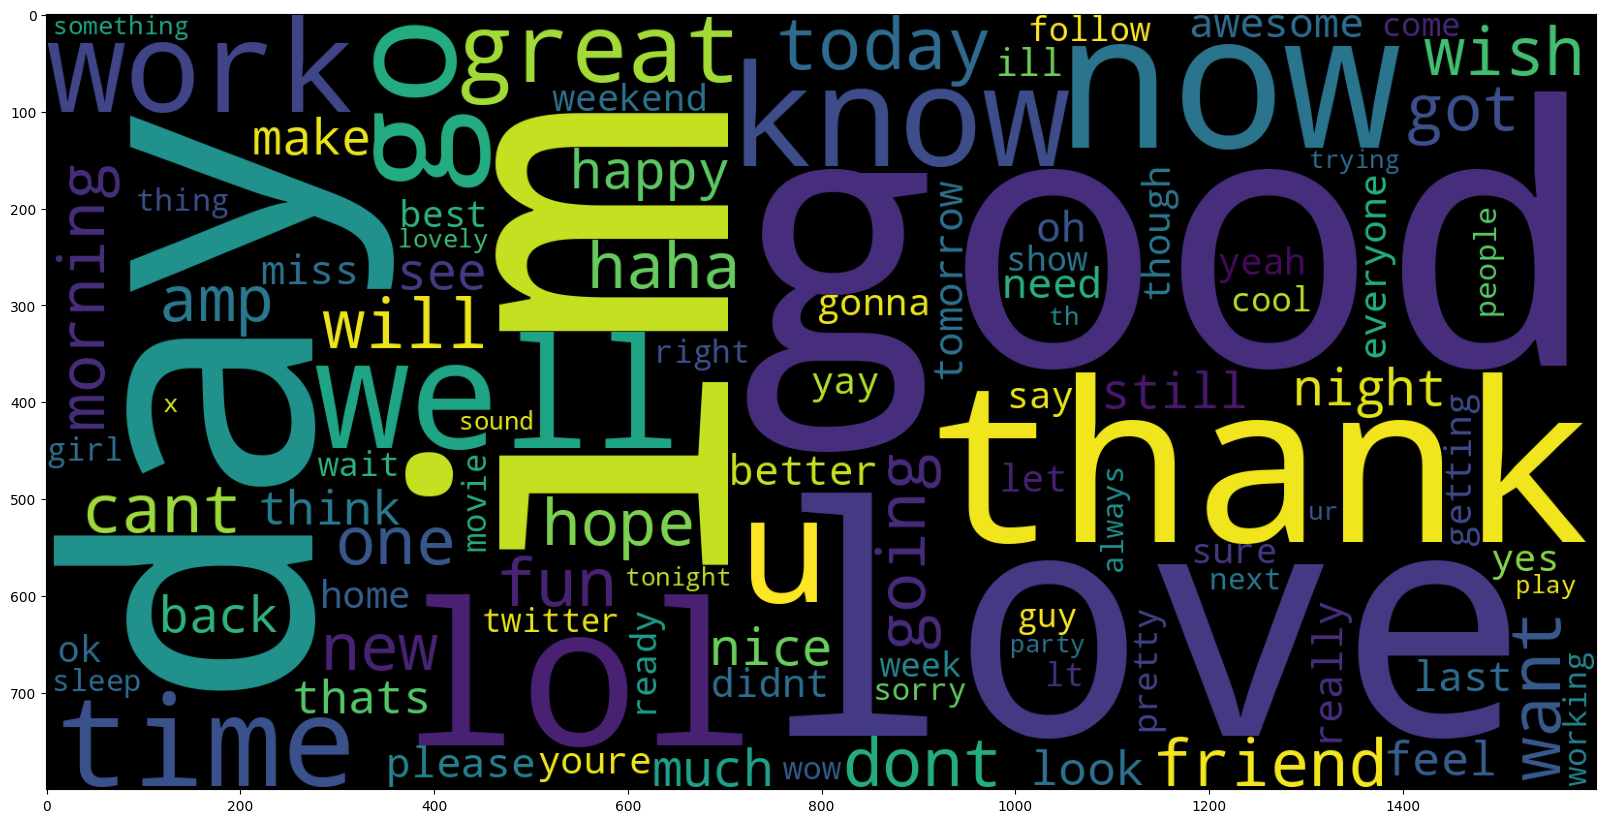

In [ ]:
# Word-Cloud for positive tweets.
filt = (df['sentiments'] == 'positive')
data_pos = df['tweets'][filt]
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

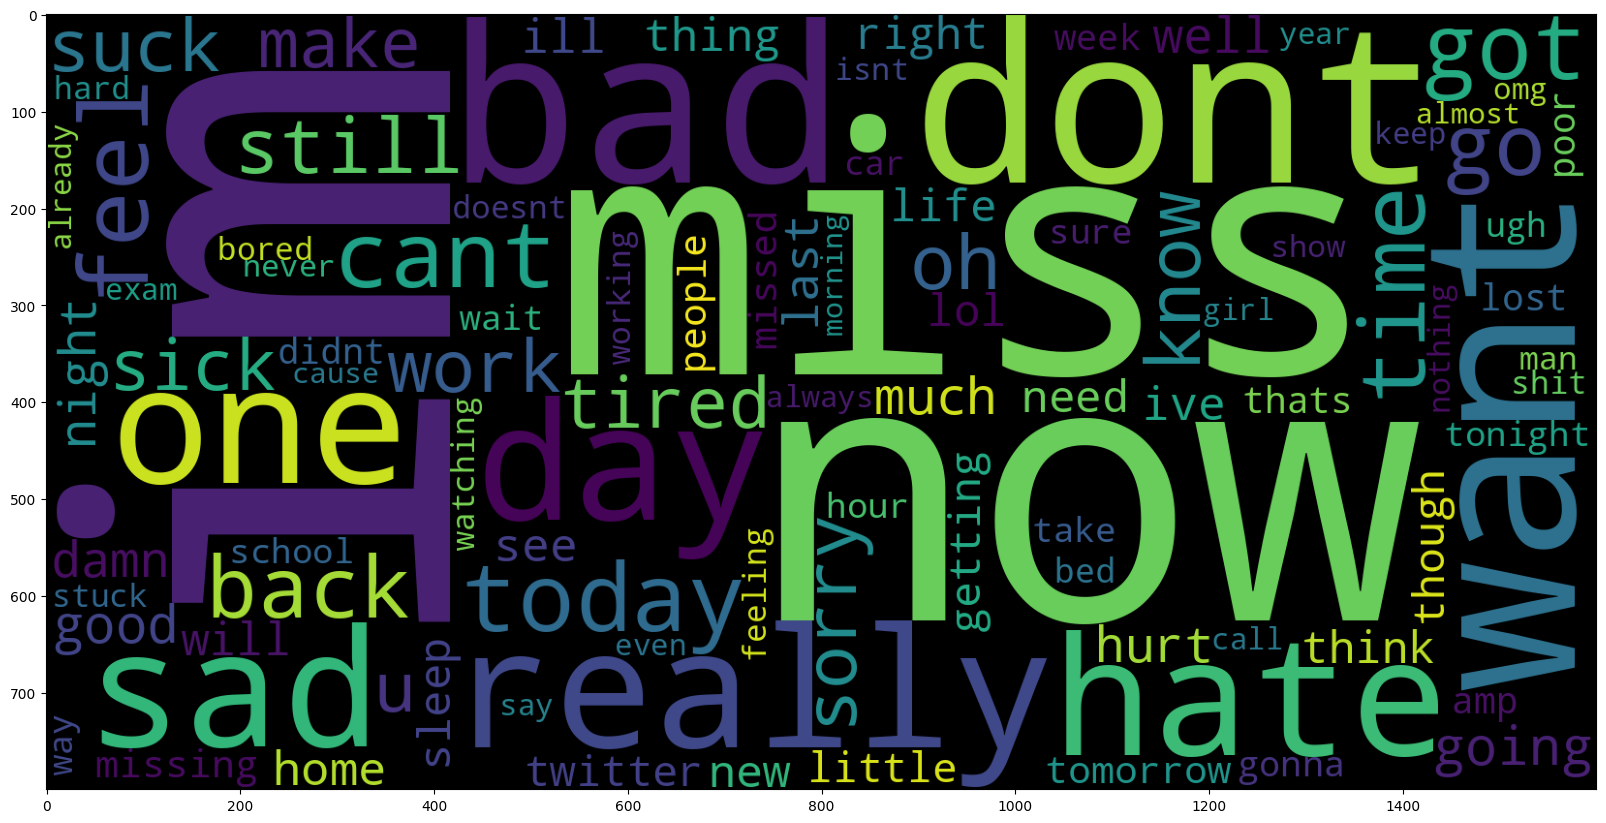

In [ ]:
# Word-Cloud for negative tweets.
filt = (df['sentiments'] == 'negative')
data_pos = df['tweets'][filt]
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweets'],df['label'],
                                                    test_size = 0.2, random_state = 0)

In [ ]:
# Create and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)


In [ ]:
# Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

X_train = vectorizer.fit_transform(X_train)
X_test  = vectorizer.fit_transform(X_test)
print(f'Data Transformed')

Data Transformed


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def model_Evaluate(model):
    # Predict values for the Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Neutral', 'Negative', 'Positive']

    # Plot the confusion matrix using seaborn
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.show()



              precision    recall  f1-score   support

           0       0.39      0.75      0.51       303
           1       0.57      0.29      0.38       456
           2       0.28      0.22      0.25       241

    accuracy                           0.41      1000
   macro avg       0.41      0.42      0.38      1000
weighted avg       0.45      0.41      0.39      1000



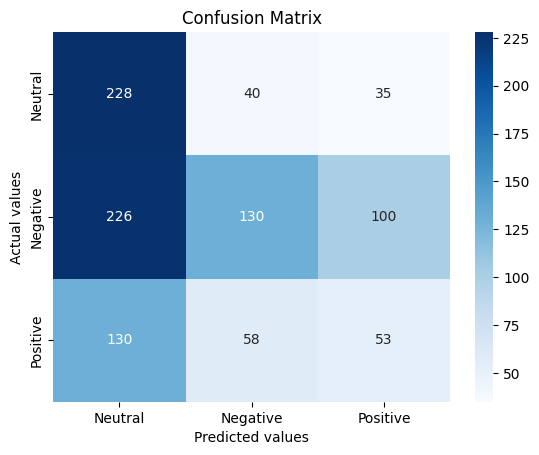

In [ ]:
# Bernouli Model
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)


              precision    recall  f1-score   support

           0       0.37      0.59      0.45       303
           1       0.50      0.36      0.42       456
           2       0.26      0.20      0.23       241

    accuracy                           0.39      1000
   macro avg       0.38      0.38      0.37      1000
weighted avg       0.40      0.39      0.38      1000



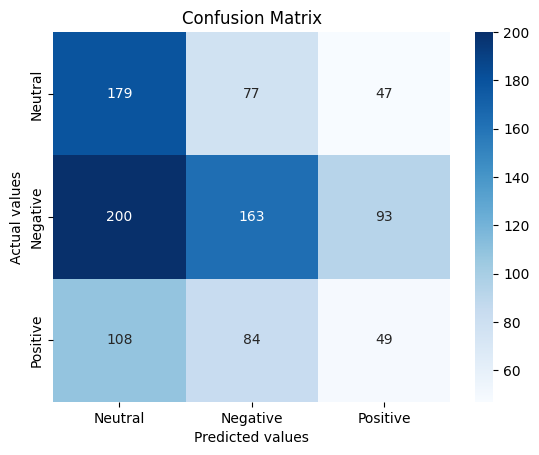

In [ ]:
# Support Vector Machine model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.36      0.66      0.47       303
           1       0.53      0.38      0.44       456
           2       0.33      0.17      0.23       241

    accuracy                           0.41      1000
   macro avg       0.41      0.40      0.38      1000
weighted avg       0.43      0.41      0.40      1000



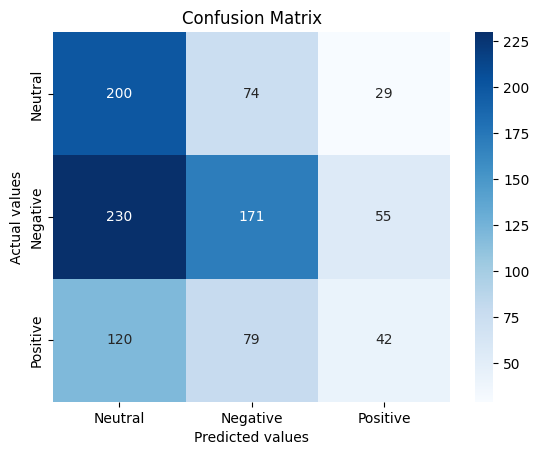

In [ ]:
# Linear Regression model
lrmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lrmodel.fit(X_train, y_train)
model_Evaluate(lrmodel)

In [ ]:
df.head(5)

,date,id,flag,username,tweets,sentiments,label
541200,2009-06-16 18:18:13,2200003313,NO_QUERY,DEWGetMeTho77,my poor little dumpling in holmdel vids he w...,negative,2
750,2009-04-06 23:11:18,1467998601,NO_QUERY,Young_J,im off too bed i gotta wake up hella early tom...,neutral,0
766711,2009-06-23 13:40:12,2300049112,NO_QUERY,dougnawoschik,i havent been able to listen to it yet my spe...,neutral,0
285055,2009-06-01 10:26:09,1993474319,NO_QUERY,thireven,now remembers why solving a relatively big equ...,negative,2
705995,2009-06-20 12:56:51,2256551006,NO_QUERY,taracollins086,ate too much feel sick,negative,2


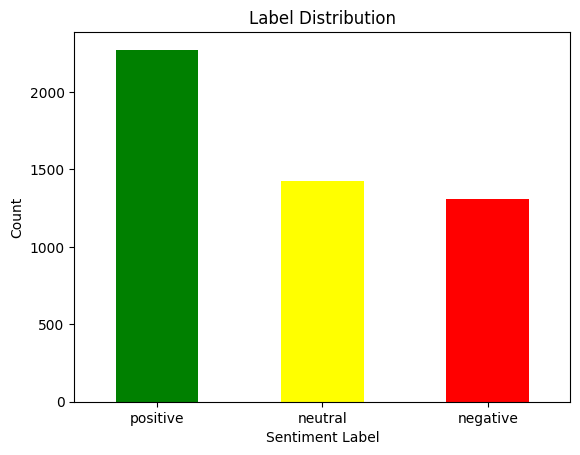

In [ ]:
# Create a bar plot of label distribution
label_counts = df['sentiments'].value_counts()
label_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


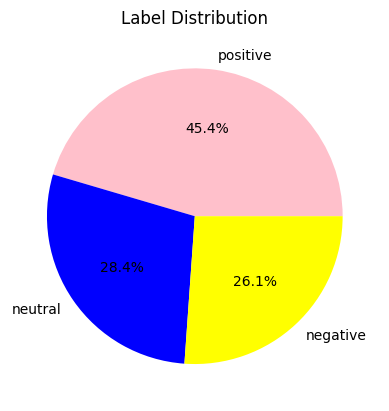

In [ ]:
# Alternatively, create a pie chart
label_counts.plot(kind='pie', autopct='%1.1f%%', colors=['pink', 'blue', 'yellow'])
plt.title('Label Distribution')
plt.ylabel('')
plt.show()